# Chapter 6
## Time Series with ARIMA
## Check-ins prediction

In [1]:
#import packages
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt 
import statsmodels
import datetime as dt
import os
import warnings



In [2]:
warnings.filterwarnings("ignore")

In [3]:
statsmodels.__version__

'0.13.2'

In [4]:
%store -r c_co_in
%store -r c_co_out

In [5]:
# get daily max check-outs
ops_day=c_co_out.groupby(c_co_out['OwnerSince'].dt.date).size().to_frame('count_')
ops_day['check_ins']=c_co_in.groupby(c_co_in['OwnerTill'].dt.date).size()
ops_day['date']=pd.to_datetime(ops_day.index)
print(ops_day.shape)
ops_day.head()

(837, 3)


,count_,check_ins,date
OwnerSince,,,
2019-09-23,62,1.0,2019-09-23
2019-09-24,13,1.0,2019-09-24
2019-09-25,21,8.0,2019-09-25
2019-09-26,19,9.0,2019-09-26
2019-09-27,15,11.0,2019-09-27


In [6]:
ops_day.tail()

,count_,check_ins,date
OwnerSince,,,
2022-02-28,123,172.0,2022-02-28
2022-03-01,417,453.0,2022-03-01
2022-03-02,377,478.0,2022-03-02
2022-03-03,244,485.0,2022-03-03
2022-03-04,78,362.0,2022-03-04


In [7]:
# create a bin including empty days between the range of earliest and latest day that a transaction took place
bins=pd.date_range(start=pd.to_datetime(ops_day.index).min(), end=pd.to_datetime(ops_day.index).max())
bins=pd.to_datetime(bins)
bins=pd.Series(bins).dt.date
bins=pd.DataFrame(bins, columns=['date'])


# add this bin as an index into df with merge operation
# now, we have all days in the df
ops_day['date']=pd.to_datetime(ops_day.index)
ops_day['date']=ops_day['date'].dt.date
ops_day.index=ops_day['date']

ops_day=pd.merge(bins,ops_day, how='left', left_on=bins['date'], \
                 right_index=True).fillna(0).drop(['date_y'], axis=1).rename(columns={'date_x':'date'}).set_index('date')
ops_day['date']=pd.to_datetime(ops_day.index)
print(ops_day.shape)

(894, 3)


In [8]:
last_date=dt.datetime(2022, 3, 3).date()
ops_day=ops_day[ops_day.index<=last_date]

In [9]:
# create a new df after grouping by week.
# What is the max daily volume in a week?
ops_week=ops_day.groupby([ops_day['date'].dt.year, ops_day['date'].dt.isocalendar().week]).max()

ops_week['year_week']=ops_week.index



ops_week.drop((2022,52), inplace=True)
ops_week.tail()

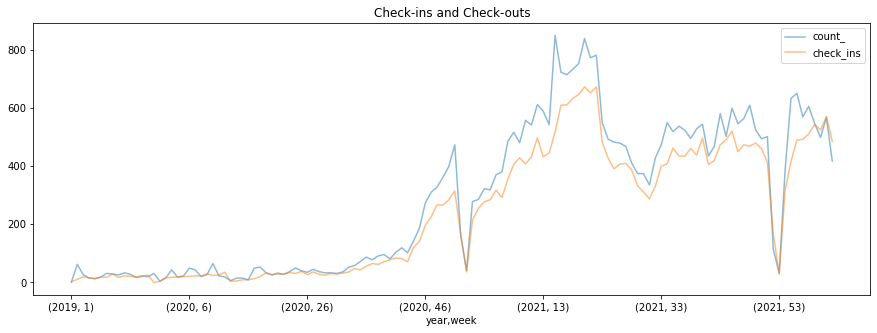

In [22]:
# plot


ops_week.index.names = ['year','week']
ops_week[['count_','check_ins']].plot(figsize=(15, 5), legend=True,  alpha=0.5)

plt.title('Check-ins and Check-outs')
plt.show()


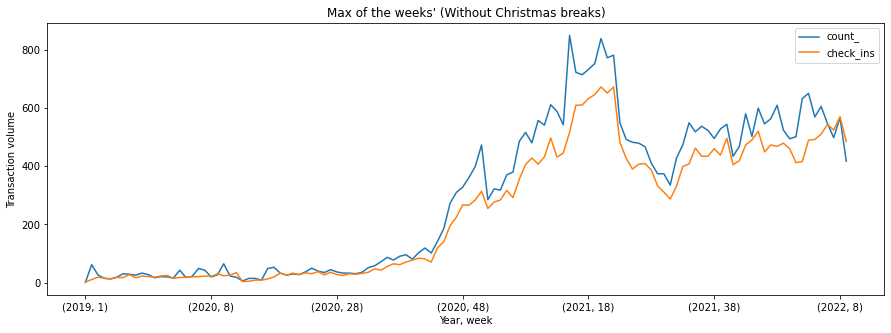

In [21]:
# Since we know drops at christmas time, we drop them...
#ops=ops_week[(2021,40):(2022,8)]['count_'].drop([(2021,52),(2021,53),(2022,1)]).reset_index()['count_']
ops=ops_week.drop([(2019,52),(2020,1),(2020,52),(2020,53),(2021,1),(2021,52),(2021,53),(2022,1)])
#ops=ops_week.drop([(2020,53),(2021,53)])#.reset_index() # drop fractional weeks 
# plot




ops[['count_','check_ins']].plot(figsize=(15, 5))
plt.title("Max of the weeks' (Without Christmas breaks)")
plt.xlabel('Year, week')
plt.ylabel('Transaction volume')
plt.show()

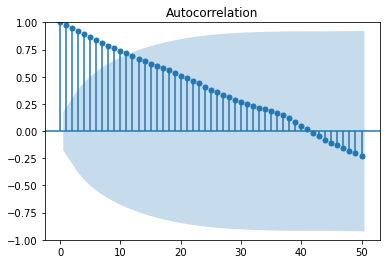

In [30]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

#plt.title('Autocorrelation')
p=plot_acf(ops['check_ins'], lags=50)


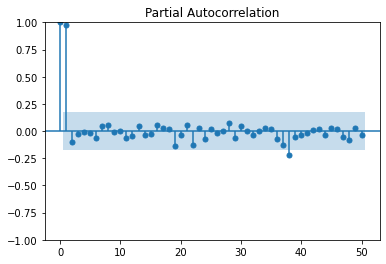

In [31]:
p=plot_pacf(ops['check_ins'], method='ywm', lags=50)

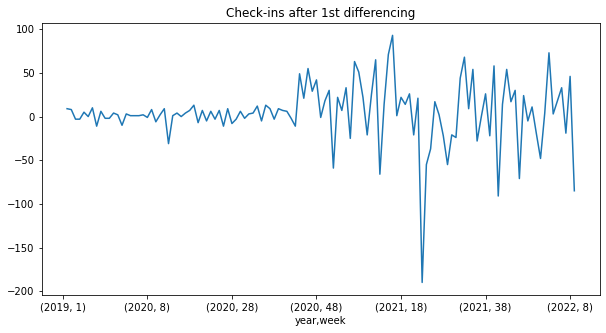

In [32]:
plt.figure(figsize=(10, 5))
plt.title('Check-ins after 1st differencing')
ops['check_ins'].diff().plot()
plt.show()

In [27]:
# adf füller test
from statsmodels.tsa.stattools import adfuller

print('without differencing:',adfuller(ops['check_ins'].dropna())[1]) # p-value is not significant. 
print('1st differencing:',adfuller(ops['check_ins'].diff().dropna())[1]) # p-value is significant
# The series is stationary...

without differencing: 0.7927403054943505
1st differencing: 1.955202293224284e-18


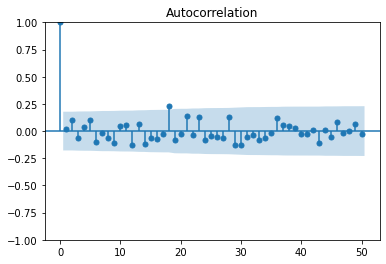

In [34]:

p=plot_acf(ops['check_ins'].diff().dropna(), lags=50)


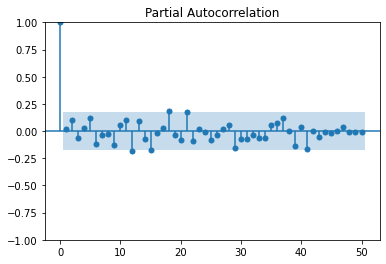

In [35]:
p=plot_pacf(ops['check_ins'].diff().dropna(), method='ywm', lags=50) # 1st differencing

In [36]:
ops.tail()

count_  check_ins       date  year_week
year week                                         
2022 5      605.0      510.0 2022-02-06  (2022, 5)
     6      547.0      543.0 2022-02-13  (2022, 6)
     7      498.0      524.0 2022-02-20  (2022, 7)
     8      567.0      570.0 2022-02-27  (2022, 8)
     9      417.0      485.0 2022-03-03  (2022, 9)

 ### Interaction between series; Check-ins vs. check-outs
 Sources: <br>
 https://towardsdatascience.com/fun-with-arma-var-and-granger-causality-6fdd29d8391c <br>
 https://livebook.manning.com/book/time-series-forecasting-in-python-book/chapter-10/v-10
 <br>

In [65]:
import statsmodels.api as sm
from statsmodels.tsa.api import VAR

#instantiate the VAR fuction on time series data
model = VAR(ops[['check_ins','count_']])
for i in ['aic', 'bic', 'hqic']:
    #maxlags takes the number of lags we want to test
    #ic takes the information criterion metod based on which order would be suggested
    results = model.fit(maxlags=5, ic=i)
    order = results.k_ar
    print(f"The suggested VAR order from {i} is {order}")

The suggested VAR order from aic is 4
The suggested VAR order from bic is 1
The suggested VAR order from hqic is 1


In [69]:
model_fit = model.fit(maxlags = 1, ic = 'bic', trend = 'c')
print(model_fit.summary())


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 05, Jul, 2022
Time:                     10:30:30
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    14.5530
Nobs:                     121.000    HQIC:                   14.4707
Log likelihood:          -1209.45    FPE:                1.82012e+06
AIC:                      14.4144    Det(Omega_mle):     1.73312e+06
--------------------------------------------------------------------
Results for equation check_ins
                  coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------
const                4.293736         4.439831            0.967           0.333
L1.check_ins         0.583010         0.085626            6.809           0.000
L1.count_            0.343834         0.071968            4.

In [71]:
#To test absence of significant residual autocorrelations one can use the test_whiteness method of VARResults
test_corr = model_fit.test_whiteness(nlags=2, signif=0.05, adjusted=False)

##Print the p-value
##There is no serial autocorrelation in residuals if p-value is more than 0.05
test_corr.pvalue

0.024786152351638616

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.00156D+01    |proj g|=  7.52204D-02

At iterate    5    f=  1.00139D+01    |proj g|=  2.86323D-03

At iterate   10    f=  1.00127D+01    |proj g|=  1.38593D-02

At iterate   15    f=  1.00125D+01    |proj g|=  3.60778D-03

At iterate   20    f=  1.00123D+01    |proj g|=  3.56162D-04

At iterate   25    f=  1.00123D+01    |proj g|=  2.51494D-03


 This problem is unconstrained.



At iterate   30    f=  1.00123D+01    |proj g|=  4.03878D-04

At iterate   35    f=  1.00122D+01    |proj g|=  2.59528D-03

At iterate   40    f=  1.00122D+01    |proj g|=  3.82474D-03

At iterate   45    f=  1.00121D+01    |proj g|=  3.19757D-04

At iterate   50    f=  1.00121D+01    |proj g|=  5.28326D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     50     53      1     0     0   5.283D-04   1.001D+01
  F =   10.012110286212454     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
                              Statespace Model Results                             
Dep. Variable:     ['check_in

/Users/kultiginbozdemir/opt/anaconda3/envs/vytal/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


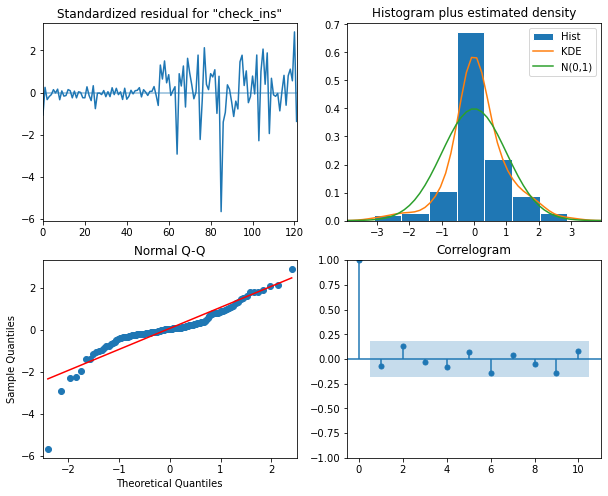

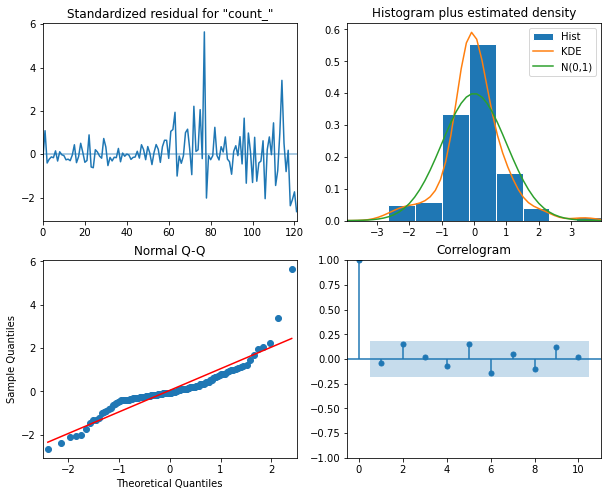

In [63]:
from statsmodels.tsa.statespace.varmax import VARMAX
model = VARMAX(ops[['check_ins','count_']], order=(1, 0)).fit(dips=False,trend = 'c')
print(model.summary())
p=model.plot_diagnostics(figsize=(10,8), variable=0)
p=model.plot_diagnostics(figsize=(10,8), variable=1)

Before we deploy the model, we need to test casuality to determine whether variables causes each other in both directions; x>y and y>x with the given lag, i.e. lag=1.


 ### Casuality Test: <br>
Null Hypothesis (H0): Time series x does not Granger-cause time series y <br>

Alternative Hypothesis (HA): Time series x Granger-causes time series y


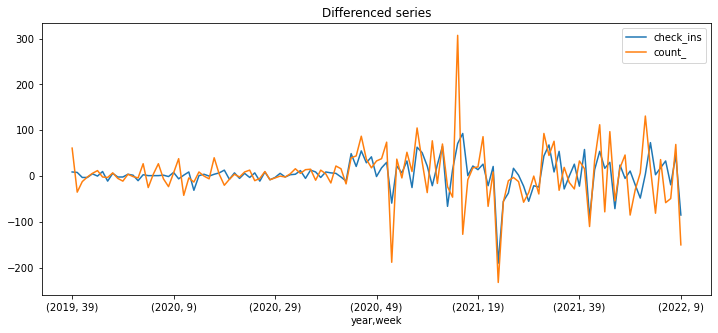

In [43]:
# prepare data for statsmodel grangercausalitytests
x=ops['check_ins'].diff()[1:]
y=ops['count_'].diff()[1:]


pd.DataFrame([x,y]).T.plot(figsize=(12,5))
plt.title('Differenced series')
plt.show()

In [44]:
from statsmodels.tsa.stattools import grangercausalitytests

print(grangercausalitytests(pd.DataFrame([x,y]).T, maxlag=[1]))



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.6925  , p=0.0109  , df_denom=117, df_num=1
ssr based chi2 test:   chi2=6.8641  , p=0.0088  , df=1
likelihood ratio test: chi2=6.6750  , p=0.0098  , df=1
parameter F test:         F=6.6925  , p=0.0109  , df_denom=117, df_num=1
{1: ({'ssr_ftest': (6.692519614879515, 0.01090651560878231, 117.0, 1), 'ssr_chi2test': (6.864122681927708, 0.008794341392255219, 1), 'lrtest': (6.674984493903139, 0.009777536290889744, 1), 'params_ftest': (6.69251961487954, 0.010906515608782226, 117.0, 1.0)}, [<statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x7fe6687ca2b0>, <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x7fe669a65b20>, array([[0., 1., 0.]])])}


In [45]:
#experiment vice versa y->x
grangercausalitytests(pd.DataFrame([y,x]).T, maxlag=[1])


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1595  , p=0.6904  , df_denom=117, df_num=1
ssr based chi2 test:   chi2=0.1636  , p=0.6859  , df=1
likelihood ratio test: chi2=0.1635  , p=0.6860  , df=1
parameter F test:         F=0.1595  , p=0.6904  , df_denom=117, df_num=1


{1: ({'ssr_ftest': (0.159474944480347, 0.6903683958836309, 117.0, 1),
   'ssr_chi2test': (0.1635640456208687, 0.6858961607712324, 1),
   'lrtest': (0.16345267515634987, 0.6859974130328998, 1),
   'params_ftest': (0.1594749444803934, 0.6903683958835949, 117.0, 1.0)},
   array([[0., 1., 0.]])])}

#### Conclude the Granger Casuality Test
As we see from the p-values, there is one direction interaction x>y, rather than a bileteral interaction. Thus, we cannot use VAR model, but ARIMAX. Check-out would be a predictor for Check-ins.


### Predict Check-ins with SARIMAX ,  Exog=Check-outs

In [505]:
import statsmodels.api as sm


In [48]:
ops=ops.reset_index()


train_break=115
ops[train_break:].tail()



,year,week,count_,check_ins,date,year_week
117,2022,5,605.0,510.0,2022-02-06,"(2022, 5)"
118,2022,6,547.0,543.0,2022-02-13,"(2022, 6)"
119,2022,7,498.0,524.0,2022-02-20,"(2022, 7)"
120,2022,8,567.0,570.0,2022-02-27,"(2022, 8)"
121,2022,9,417.0,485.0,2022-03-03,"(2022, 9)"


In [87]:
# Grid search to find best q
# In this case bic is better.
#See https://towardsdatascience.com/fun-with-arma-var-and-granger-causality-6fdd29d8391c

best=10**1000
m_=()
for q in range(3):

    #print(1,1,q)
    arima_model= sm.tsa.statespace.SARIMAX(ops[:train_break]['check_ins'],ops[:train_break]['count_'],
                                           enforce_invertibility=False, order=(1,1,q))
    model=arima_model.fit(disp=False)
    #print(model.bic)
    if model.bic<best:
        best=model.bic
        m_=(1,1,q)
print('....result...')           
print(m_, best)




....result...
(1, 1, 0) 1090.5258723984978


In [91]:
arima_model=sm.tsa.statespace.SARIMAX( ops[:train_break]['check_ins'],ops[:train_break]['count_'], 
                                      order=m_, enforce_invertibility=False,)
model=arima_model.fit(disp=False)
ops['fitted_values']=model.predict() # save fitted values

# rolling prediction
for i,row in ops[train_break:].iterrows():
    # append one step without fitting the model again
    model=model.append(endog=[row['check_ins']], exog=[row['count_']], refit=False)
    ops.loc[i,'pred']=model.predict().loc[i] # save the prediction


ops.tail(10)

,year,week,count_,check_ins,date,year_week,fitted_values,pred
112,2021,50,494.0,460.0,2021-12-19,"(2021, 50)",455.295528,NaN
113,2021,51,501.0,412.0,2021-12-26,"(2021, 51)",464.541278,NaN
114,2022,2,632.0,416.0,2022-01-16,"(2022, 2)",478.317749,NaN
115,2022,3,650.0,489.0,2022-01-23,"(2022, 3)",NaN,435.747477
116,2022,4,569.0,492.0,2022-01-30,"(2022, 4)",NaN,439.469981
117,2022,5,605.0,510.0,2022-02-06,"(2022, 5)",NaN,497.719732
118,2022,6,547.0,543.0,2022-02-13,"(2022, 6)",NaN,485.441226
119,2022,7,498.0,524.0,2022-02-20,"(2022, 7)",NaN,508.786897
120,2022,8,567.0,570.0,2022-02-27,"(2022, 8)",NaN,551.984230
121,2022,9,417.0,485.0,2022-03-03,"(2022, 9)",NaN,504.162433


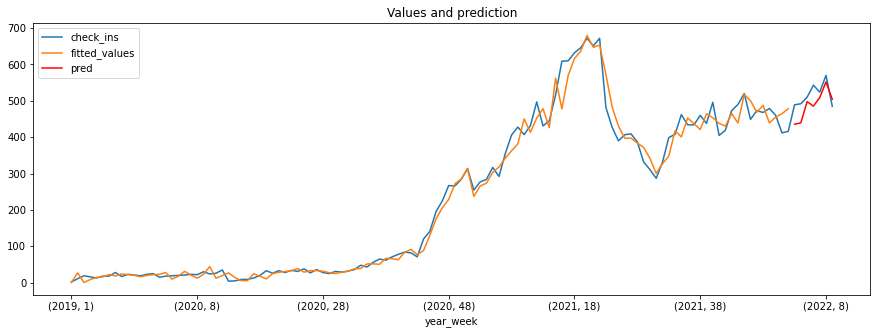

mae; 32.573269745372976


In [86]:
# Plot
ops.set_index('year_week')[['check_ins','fitted_values']].plot(figsize=(15,5))
ops['pred'].plot(color='red')
plt.title('Values and prediction')
plt.legend()
plt.show()

mae=np.mean(np.abs(ops[train_break:]['check_ins']-ops[train_break:]['pred'])) # mean absolute error

print('mae;',mae)